In [1]:
from __future__ import unicode_literals, print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils import data
from torch.autograd import Variable
import warnings
import kornia
import radialProfile
import kornia
warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# u = torch.load("Results/Results_64/U.pt")
# cnn = torch.load("Results/Results_64/ResNet.pt")
# convlstm = torch.load("Results/Results_64/ConvLSTM.pt")
# sst = torch.load("Results/Results_64/SST.pt")
# dhpm = torch.load("Results/Results_64/DHPM.pt")
# gan = torch.load("Results/Results_64/GAN.pt")
# tf = torch.load("Results/Results_64/TF.pt")
# tf_con = torch.load("Results/Results_64/TF_con.pt")

# These experiments were all run on UNNORMALIZED images
results = torch.load("../../tf_net_results/karman_2d_results_init.pt")
print(f'device: {device}')
results.keys()

device: cuda


dict_keys(['preds', 'trues', 'loss_curve'])

In [3]:
colors = ["k", "tab:orange", "tab:blue", "tab:red", "tab:green", "tab:purple", "tab:brown", "tab:grey", "tab:pink", "tab:orange"]
title = ["Target", "Con TF-net", "TF-net", "U_net",  "GAN",  "ResNet", "ConvLSTM",  "SST",  "DHPM"]#"U_con",
markers = ['o',  "H", 'v', "*", "X", "d", "P",'s', "^"]

In [4]:
avg = 1.0424337
stds = 4522.7046
# multiply by stds and add avg to recover the prediction from normalization (z = (x-mean)/std)
# preds = [gan["trues"]*stds+avg, tf_con["preds"]*stds+avg, tf["preds"]*stds+avg, u["preds"]*stds+avg,  gan["preds"]*stds+avg,cnn["preds"]*stds+avg, convlstm["preds"]*stds+avg, sst["preds"]*stds+avg, dhpm["preds"]*stds+avg]
preds = [results["trues"], results["preds"]]
print(preds[0].shape)

(2400, 4, 2, 256, 128)


### RMSE vs. Prediction Steps

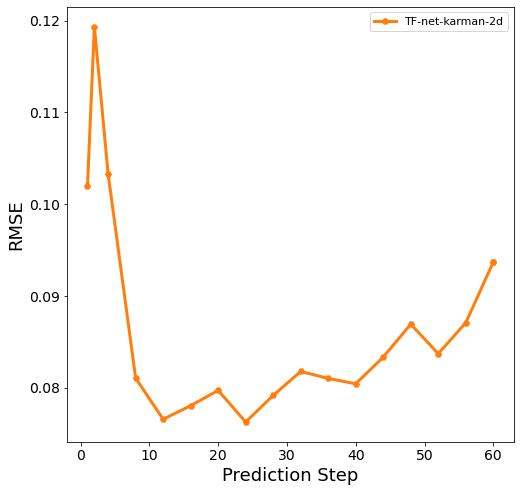

In [5]:
fig=plt.figure(figsize=(8, 8))
idx = np.array([0,1] + list(range(3,60,4))+[59])
#idx = np.array([0,1] + list(range(3,40,4))+[39])
# plt.plot(idx+1, tf_con['loss_curve'][idx]*stds, label = "Con TF-net", marker=markers[1], linewidth = 1.5, color = colors[1])
plt.plot(idx+1,  results['loss_curve'][idx], label = "TF-net-karman-2d", marker=markers[1], linewidth = 3, color = colors[1])

plt.ylabel("RMSE", size = 18)
plt.xlabel("Prediction Step", size = 18)
plt.legend(fontsize=11)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.savefig("rmse_horizon.png", dpi = 400, bbox_inches = 'tight')
plt.show()

### Kinetic Energy

In [15]:
def inverse_seqs(tensor):
    tensor = tensor.reshape(-1,7, 4, 2, 256, 128)
    #tensor = tensor.reshape(-1,7, 60, 2, 64, 64)
    tensor = tensor.transpose(0,2,3,1,4,5)
    tensor = tensor.transpose(0,1,2,4,3,5).reshape(-1, 4, 2, 64, 448)
    #tensor = tensor.transpose(0,1,2,4,3,5).reshape(-1, 60, 2, 64, 448)
    tensor = tensor.transpose(0,2,1,3,4)
    return tensor

def TKE(preds):
    mean_flow = np.expand_dims(np.mean(preds, axis = 1), axis = 1)
    tur_preds = np.mean((preds - mean_flow)**2, axis = 1)
    tke = (tur_preds[0] + tur_preds[1])/2
    return tke

def tke2spectrum(tke):
    """Convert TKE field to spectrum"""
    sp = np.fft.fft2(tke)
    sp = np.fft.fftshift(sp)
    sp = np.real(sp*np.conjugate(sp))
    sp1D = radialProfile.azimuthalAverage(sp)
    return sp1D 

def spectrum_band(tensor):
    tensor = inverse_seqs(tensor)
    spec = np.array([tke2spectrum(TKE(tensor[i])) for i in range(tensor.shape[0])])
    return np.mean(spec, axis = 0), np.std(spec, axis = 0)

def inverse_seqs(tensor):
    #tensor = tensor.reshape(-1,7, 60, 2, 64, 64)
    tensor = tensor.reshape(-1,7, 4, 2, 256, 128)
    tensor = tensor.transpose(0,2,3,1,4,5)
    #tensor = tensor.transpose(0,1,2,4,3,5).reshape(-1, 60, 2, 64, 448)
    tensor = tensor.transpose(0,1,2,4,3,5).reshape(-1, 4, 2, 64, 448)
    tensor = tensor.transpose(0,2,1,3,4)
    return tensor

def TKE_mean(tensor):
    if tensor.shape[-1] == 448:
        return TKE(tensor)
    print(f'tensor shape: {tensor.shape}')
    tensor = inverse_seqs(tensor)
    print(f'After inverse: {tensor.shape}')
    tke_mean = 0
    for i in range(0,min(70,tensor.shape[0])):
        tke_mean += TKE(tensor[i])
    tke_mean = tke_mean/tensor.shape[0]
    return tke_mean

tensor shape: (2394, 4, 2, 256, 128)
After inverse: (2736, 2, 4, 64, 448)
tensor shape: (2394, 4, 2, 256, 128)
After inverse: (2736, 2, 4, 64, 448)


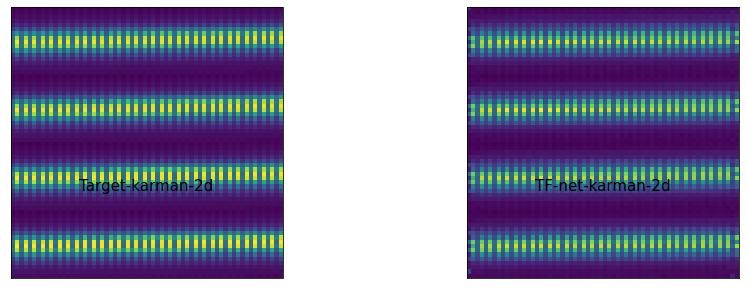

In [20]:
# the first dimension needs to be a multiple of 7 to work with inverse_seqs
preds = [results["trues"][:2394], results["preds"][:2394]]
tkes = [TKE_mean(preds[i]) for i in range(2)]
# title = ["Target","Con TF-net", "TF-net", "U_net",  "GAN",  "ResNet", "ConvLSTM",  "SST",  "DHPM"]
title = ["Target-karman-2d", "TF-net-karman-2d"]
fig=plt.figure(figsize=(15, 5))
columns = 2
rows = 1
for i in range(columns):
    fig.add_subplot(rows, columns, i+1)
    #plt.imshow(tkes[i][:64,:448])
    #plt.imshow(tkes[i])
    plt.imshow(tkes[i][:64,:64])
    plt.xlabel(title[i], size = 15, rotation=0, labelpad = -100)
    plt.xticks([])
    plt.yticks([])
plt.savefig("Karman 2D Kinetic Energy.png", dpi = 400,bbox_inches = 'tight')
plt.show()

### Divergence 

In [10]:
def divergence(preds):
    #preds: batch_size*output_steps*2*H*W
    print(f'preds.shape: {preds.shape}')
    preds_u = preds[:,:,0]
    preds_v = preds[:,:,1]
    u = torch.from_numpy(preds_u).float().to(device)
    v = torch.from_numpy(preds_v).float().to(device)
    #Sobolev gradients
    field_grad = kornia.filters.SpatialGradient()
    u_x = field_grad(u)[:,:,0]
    v_y = field_grad(v)[:,:,1]
    div = np.mean(np.abs((v_y + u_x).cpu().data.numpy()), axis = (0,2,3))
    return div

(2400, 4, 2, 256, 128)
preds.shape: (2400, 4, 2, 256, 128)
preds.shape: (2400, 4, 2, 256, 128)


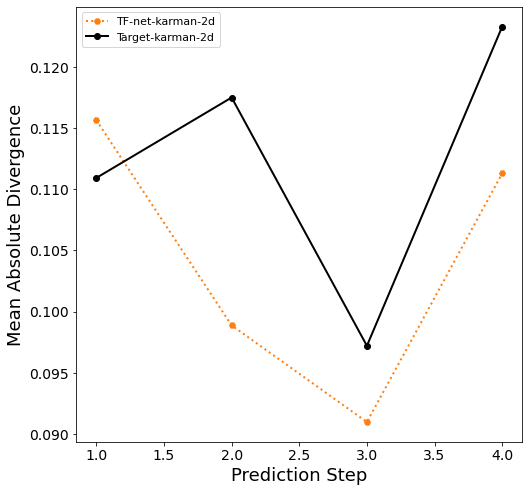

In [14]:
print(results["preds"].shape)
# Need to reduce batch size otherwise it causes problems
preds = [results["trues"], results["preds"]]
#dhpm_preds = np.expand_dims(results["preds"].transpose(1,0,2,3), axis = 0)
divs = [divergence(preds[i]) for i in range(2)]
linestyles = ['-', '--', '-.', ':','-.', '--', '-.', ':','-.','--']
fig=plt.figure(figsize=(8, 8))
#idx = np.array(list(range(0,60,4)))
idx = np.array(list(range(0,4,1)))
#for i in range(1, len(markers)):
plt.plot(idx+1, divs[1][idx], label = 'TF-net-karman-2d', marker=markers[1], linewidth = 2, linestyle=':', color = colors[1])  
plt.plot(idx+1, divs[0][idx], label = 'Target-karman-2d', marker=markers[0], linewidth = 2, linestyle=linestyles[0], color = 'k')

plt.ylabel("Mean Absolute Divergence", size = 18)
plt.xlabel("Prediction Step", size = 18)
plt.legend(fontsize=11)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("karman-2d-divergence.png", dpi = 400, bbox_inches = 'tight')
plt.show()

### Energy Spectrum

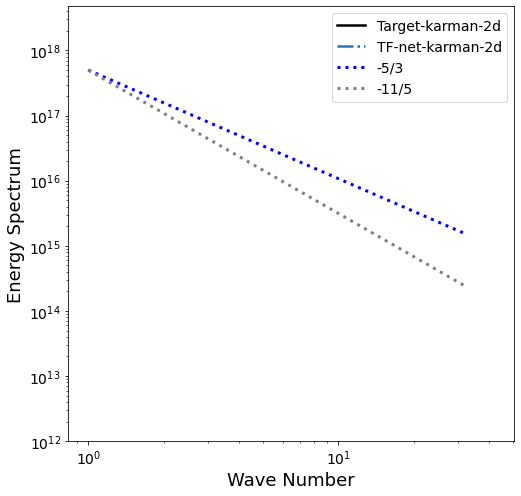

In [23]:
def inverse_seqs(tensor):
    #tensor = tensor.reshape(-1,7, 60, 2, 64, 64)
    tensor = tensor.reshape(-1,7, 4, 2, 256, 128)
    tensor = tensor.transpose(0,2,3,1,4,5)
    #tensor = tensor.transpose(0,1,2,4,3,5).reshape(-1, 60, 2, 64, 448)
    tensor = tensor.transpose(0,1,2,4,3,5).reshape(-1, 4, 2, 64, 448)
    tensor = tensor[:,:,:,:,:64]
    tensor = tensor.transpose(0,2,1,3,4)
    return tensor

preds = [results["trues"][:2394], results["preds"][:2394]]

fig=plt.figure(figsize=(8, 8))
spec_mean, spec_stds = spectrum_band(preds[0])
x_idx = np.array(list(range(0,len(spec_mean))))
plt.plot(x_idx, spec_mean[x_idx], label = title[0], linewidth = 2.5, color = "k")

spec_mean, spec_stds = spectrum_band(preds[1])
plt.plot(x_idx, spec_mean[x_idx], label = title[1], linewidth = 2.5, color = colors[2], linestyle='-.')


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.yscale("log")
plt.xscale("log")
x_idx = np.linspace(0,5,100)
x = 2**x_idx
y = 2**(-5*x_idx/3 + np.log2(5*10e16))
plt.plot(x, y, ':b', label='-5/3',linewidth = 3)

x_idx = np.linspace(0,5,100)
x = 2**x_idx
y = 2**(-11*x_idx/5 + np.log2(5*10e16))
plt.plot(x, y, ':', label='-11/5',linewidth = 3, color = "grey")

plt.legend(fontsize=14, loc = 1)
plt.ylabel("Energy Spectrum", size = 18)
plt.xlabel("Wave Number", size = 18)
plt.ylim(10e11, )
plt.savefig("karman_2d_spec_ci_entire.png", dpi = 400, bbox_inches = 'tight')

Text(0.5, 0, 'Wave Number')

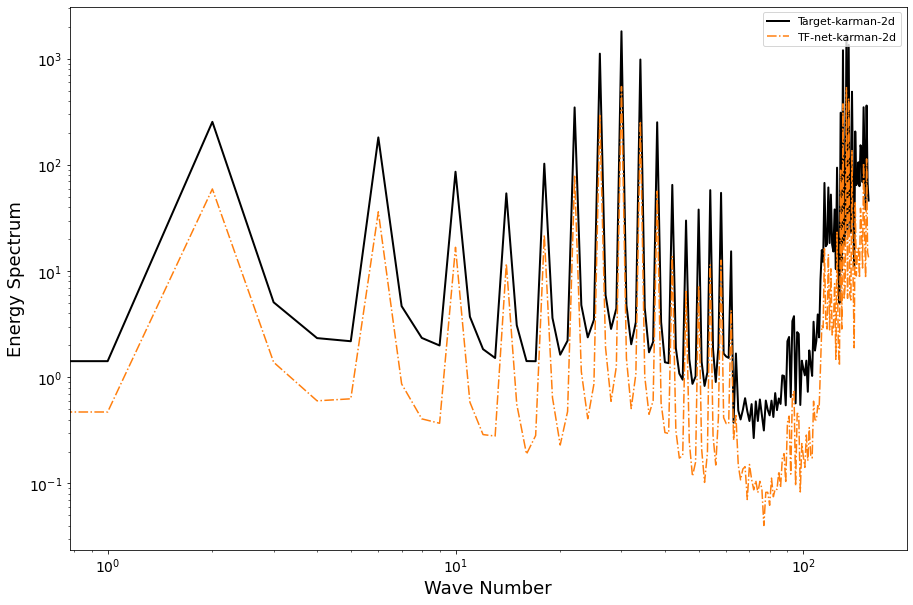

In [24]:
def inverse_seqs(tensor):
    #tensor = tensor.reshape(-1,7, 60, 2, 64, 64)
    tensor = tensor.reshape(-1,7, 4, 2, 256, 128)
    tensor = tensor.transpose(0,2,3,1,4,5)
    #tensor = tensor.transpose(0,1,2,4,3,5).reshape(-1, 60, 2, 64, 448)
    tensor = tensor.transpose(0,1,2,4,3,5).reshape(-1, 4, 2, 64, 448)
    tensor = tensor.transpose(0,2,1,3,4)
    return tensor

preds = [results["trues"][:2394], results["preds"][:2394]]

title = ["Target-karman-2d", "TF-net-karman-2d"]
fig=plt.figure(figsize=(15, 10))
x_idx = np.array(list(range(0,155)))

spec_mean, spec_stds = spectrum_band(preds[0])
plt.plot(x_idx, spec_mean[x_idx], label = title[0], linewidth = 2, color = "k")

for i in range(1, 2):
    spec_mean, spec_stds = spectrum_band(preds[i])
    if i % 2 == 1 :
        plt.plot(x_idx, spec_mean[x_idx], label = title[i], linewidth = 1.5, color = colors[i], linestyle='-.')
    else:
        plt.plot(x_idx, spec_mean[x_idx], label = title[i], linewidth = 1.5, color = colors[i])

plt.legend(fontsize=11, loc = 1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale("log")
plt.xscale("log")
plt.ylabel("Energy Spectrum", size = 18)
plt.xlabel("Wave Number", size = 18)
#plt.savefig("spec_ci_all.png", dpi = 400, bbox_inches = 'tight')

### Visualization

i : 1, j: 1
i : 1, j: 2
i : 2, j: 1
i : 2, j: 2
i : 3, j: 1
i : 3, j: 2
i : 4, j: 1
i : 4, j: 2


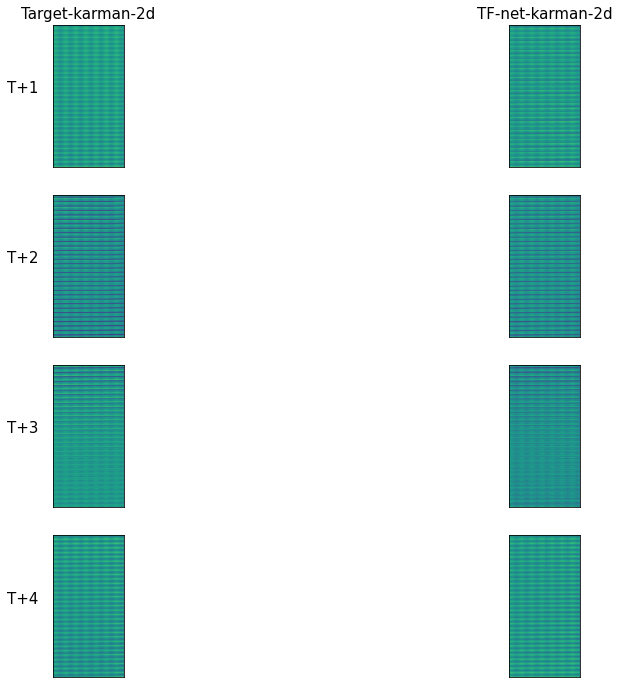

In [28]:
index = 0
direc = 0
#timesteps = [0,1,2, 4,9,19,59]
timesteps = [0,1,2, 3]
fig=plt.figure(figsize=(15, 12))
columns = 2
rows = 4
for i in range(1, rows+1):
    for j in range(1, columns+1):
        fig.add_subplot(rows, columns, (i-1)*columns+j)
        #print(f'i : {i}, j: {j}')
        if j == 11:
             plt.imshow(preds[j-1][direc,timesteps[i-1],:64,:64])
        else:
            if j == 1:
                plt.imshow(preds[j-1][index][timesteps[i-1],direc])
                plt.ylabel("T+"+str(timesteps[i-1]+1), size = 15 ,rotation=0, labelpad=30)
                #plt.imshow(preds[j-1][direc,timesteps[i-1],:64,:64])
            else:
                plt.imshow(preds[j-1][index][timesteps[i-1],direc])
        
        if i == 1:
            plt.title(title[j-1], size = 15)
        plt.xticks([])
        plt.yticks([])
plt.savefig("karman-2d-velocity_u.png", dpi = 400, bbox_inches = 'tight')
plt.show()

## Videos

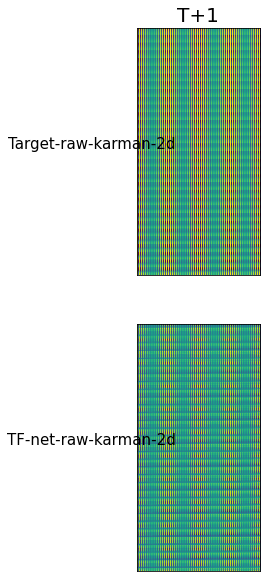

In [26]:
direc = "/global/cscratch1/sd/rwang2/TF-net/Evaluation/Videos/Videos_Entire_Domain/"
# Target = torch.load(direc + "TF.pt")["trues"]
# TF = torch.load(direc + "TF.pt")["preds"]
# U = torch.load(direc +"U.pt")["preds"]
# ResNet = torch.load(direc +"ResNet.pt")["preds"]
# GAN = torch.load(direc +"GAN.pt")["preds"]

#preds = [Target,  TF,  U,  ResNet, GAN]
preds = [results["trues"], results["preds"]]
#preds = [results["trues"], results["preds"], orig_attempt["trues"][:357], orig_attempt["preds"][:357], region["trues"][:287]*stds+avg, region["preds"][:287]*stds+avg]
index = 0
direc = 0
rows = 2
ylabels = ["Target-raw-karman-2d", "TF-net-raw-karman-2d"]
fig=plt.figure(figsize=(15, 10))

for timesteps in range(60):
    for i in range(1, rows+1):
        fig.add_subplot(rows, 1, i)
        plt.imshow(preds[i-1][index][timesteps, direc])
        plt.ylabel(ylabels[i-1], size = 15 ,rotation=0, labelpad=45)
        if i == 1:
            plt.title("T+"+str(timesteps+1), size = 20)
        plt.xticks([])
        plt.yticks([])
    break
    """
    if timesteps < 10:
        plt.savefig('/global/cscratch1/sd/rwang2/TF-net/TF-net/Entire_Domain/Imgs/im_' + str(0) + str(timesteps) + ".png", 
                         dpi = 400, bbox_inches = 'tight')
    else:
        plt.savefig('/global/cscratch1/sd/rwang2/TF-net/TF-net/Entire_Domain/Imgs/im_' + str(timesteps) + ".png", 
                        dpi = 400, bbox_inches = 'tight')
    """